<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_cnn(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Intent Classification using Pre-trained Word Embedding

* 의도 분류(Intent Classification)는 개체명 인식(Named Entity Recognition)과 더불어 챗봇(Chatbot)의 중요 모듈로서 사용되기도 함

## 1.1 Data load

[훈련 데이터 다운로드 링크](https://drive.google.com/file/d/1cnQJPx5JuphsWO3qVAo5tMUPswjDn2Fz/view?usp=sharing)

[테스트 데이터 다운로드 링크](https://drive.google.com/file/d/1euW8e7oJELyLo-3dNuGBhVxwtvoV3vgK/view?usp=sharing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

In [3]:
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

In [4]:
print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


In [6]:
# 샘플 확인
print(intent_train[:2])
print(label_train[:2])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams']
['AddToPlaylist', 'AddToPlaylist']


In [7]:
print(intent_train[2000:2002])
print(label_train[2000:2002])

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
['BookRestaurant', 'BookRestaurant']


In [8]:
print(intent_train[4000:4002])
print(label_train[4000:4002])

['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
['GetWeather', 'GetWeather']


In [9]:
print(intent_train[6000:6002])
print(label_train[6000:6002])

['rate the current album one points', 'i give a zero rating for this essay']
['RateBook', 'RateBook']


In [10]:
print(intent_train[8000:8002])
print(label_train[8000:8002])

["i'm trying to find the show chant ii", 'find spirit of the bush']
['SearchCreativeWork', 'SearchCreativeWork']


In [11]:
print(intent_train[10000:10002])
print(label_train[10000:10002])

['when is blood and ice cream trilogie playing at the nearest movie theatre \\?', 'show movie schedules']
['SearchScreeningEvent', 'SearchScreeningEvent']


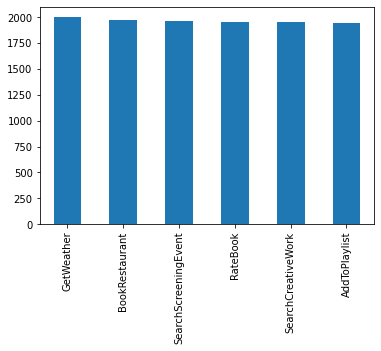

In [12]:
# 레이블 분포 확인 (시각화)
train_data['label'].value_counts().plot(kind = 'bar')

## 1.2 Data preprocessing

In [13]:
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [14]:
# 레이블에 정수 인코딩 수행
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train) # 정수 인코딩
label_test = idx_encode.transform(label_test) # 정수 인코딩

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [17]:
# 텍스트에 정수 인코딩 수행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)

In [18]:
# vocab size
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # 패딩 토큰(0) 고려
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


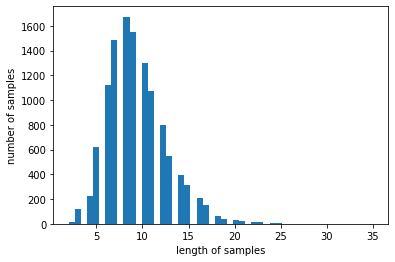

In [19]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# max_len으로 패딩
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)

# 레이블(0~5)에 원핫 인코딩 수행
label_train = to_categorical(np.asarray(label_train))

print('전체 데이터의 크기(shape):', intent_train.shape)
print('레이블 데이터의 크기(shape):', label_train.shape)

전체 데이터의 크기(shape): (11784, 35)
레이블 데이터의 크기(shape): (11784, 6)


In [21]:
# 전처리 결과 확인
print(intent_train[0])
print(label_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
[1. 0. 0. 0. 0. 0.]


In [22]:
# random index sequence
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)

# shuffle train data by random index
intent_train = intent_train[indices]
label_train = label_train[indices]

* 훈련 데이터가 일정한 순서로 배치되어져 있으므로 현재 훈련 데이터에서 앞의 10%나 중간 10%나 뒤의 10%를 검증 데이터로 분리했다가는 운이 나쁘면 특정 레이블의 데이터들만을 분리할 수도 있음

In [23]:
# Data Split (train-val)
n_of_val = int(0.1 * intent_train.shape[0])

X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test

print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 개수(shape):', y_train.shape)
print('검증 데이터 레이블의 개수(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 개수(shape): (10606, 6)
검증 데이터 레이블의 개수(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


## 1.3 Pretrained Word Embedding

In [ ]:
# Pretrained GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [26]:
import os

embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [27]:
# 사전훈련 임베딩 벡터값으로 임베딩 테이블 생성
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 1.4 Modeling

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout, Conv1D, Concatenate, GlobalMaxPooling1D, Dense

In [43]:
kernel_size = [3,4,5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable = False)(model_input)

conv_blocks = []

for size in kernel_size:
  conv = Conv1D(filters= num_filters, kernel_size=size, strides=1, padding='valid', activation='relu')(output)
  conv = GlobalMaxPooling1D()(conv)
  conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)

In [44]:
model = Model(inputs=model_input, outputs=model_output)

In [45]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 100)      987000      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 33, 512)      154112      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 32, 512)      205312      embedding_2[0][0]                
____________________________________________________________________________________________

In [46]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split = 0.2, verbose=1)

Epoch 1/10
133/133 [==============================] - 13s 94ms/step - loss: 0.2162 - acc: 0.9288 - val_loss: 0.0659 - val_acc: 0.9826
Epoch 2/10
133/133 [==============================] - 12s 93ms/step - loss: 0.0499 - acc: 0.9854 - val_loss: 0.0583 - val_acc: 0.9821
Epoch 3/10
133/133 [==============================] - 12s 93ms/step - loss: 0.0275 - acc: 0.9933 - val_loss: 0.0500 - val_acc: 0.9844
Epoch 4/10
133/133 [==============================] - 12s 92ms/step - loss: 0.0172 - acc: 0.9960 - val_loss: 0.0462 - val_acc: 0.9873
Epoch 5/10
133/133 [==============================] - 12s 92ms/step - loss: 0.0127 - acc: 0.9972 - val_loss: 0.0464 - val_acc: 0.9896
Epoch 6/10
133/133 [==============================] - 12s 93ms/step - loss: 0.0097 - acc: 0.9979 - val_loss: 0.0474 - val_acc: 0.9877
Epoch 7/10
133/133 [==============================] - 12s 93ms/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0476 - val_acc: 0.9868
Epoch 8/10
133/133 [==============================] - 12s 92ms

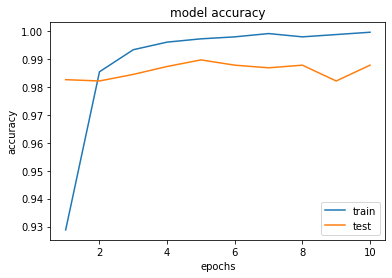

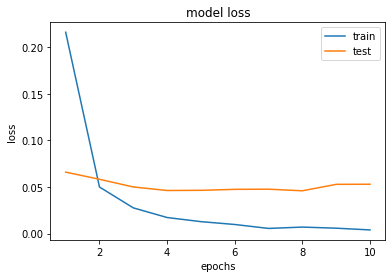

In [47]:
# 결과 그래프 시각화

# accuracy
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# loss
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 1.5 Predict

In [48]:
# 테스트 텍스트 데이터 정수 인코딩 및 패딩
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

# predict
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 정수 인덱스들의 시퀀스로 변환

In [52]:
# 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
y_predicted = idx_encode.inverse_transform(y_predicted)
y_test = idx_encode.inverse_transform(y_test)

* ```python
  idx_encode.inverse_transform([0])

  >>> array(['AddToPlaylist'], dtype='<U20')
  ```

In [53]:
from sklearn.metrics import classification_report

print('accuracy: ', sum(y_predicted == y_test) / len(y_test))
print("Precision, Recall and F1-Score:\n\n", classification_report(y_test, y_predicted))

accuracy:  0.9833333333333333
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       0.99      0.99      0.99       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.93      1.00      0.96       100
SearchScreeningEvent       1.00      0.91      0.95       100

            accuracy                           0.98       600
           macro avg       0.98      0.98      0.98       600
        weighted avg       0.98      0.98      0.98       600



# 2) Character Embedding

## 2.1 Char Embedding (1D CNN)

* 1D CNN은 전체 시퀀스 입력 내부의 더 작은 시퀀스로부터 정보를 얻어내는 동작을 하는 알고리즘
* FastText가 글자의 N-gram의 조합을 이용하여 OOV 문제를 해결하였듯이, 1D CNN을 글자 임베딩에 사용할 경우에는 글자의 N-gram으로부터 정보를 얻어냄

__[단어 'have'에 대해서 1D CNN을 통해서 단어 표현 벡터를 얻는 과정]__

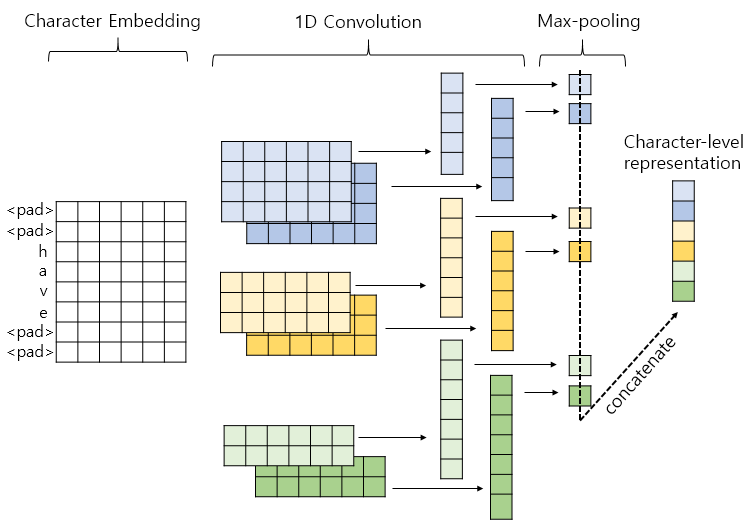

* 단어 'have'를 'h', 'a', 'v', 'e'와 같이 글자 단위로 분리
* 임베딩 층을 이용해 글자를 임베딩(워드 임베딩 후 문장의 길이를 맞추기 위해 패딩을 하는 것과 마찬가지로 패딩을 할 수도 있음)
* 1D CNN층을 적용하여 얻은 벡터가 6개므로 맥스 풀링을 한 후에는 6개의 스칼라 값을 얻는데, 이렇게 얻은 스칼라값들은 전부 연결(concatenate)하여 하나의 벡터로 만들어줌
* 최종적으로 이렇게 얻은 벡터를 단어 'have'의 벡터로 사용함

이렇게 단어 벡터를 얻을 경우, 어떤 단어이든 기본적으로 글자 레벨로 쪼개므로 OOV 문제 또한 해결할 수 있음
* 특정 영단어가 훈련 데이터에 없었으나 테스트 데이터에 존재하는 단어일 때, Word2Vec이나 GloVe의 경우에는 OOV 문제가 발생하게 됨
* 반면 1D CNN을 이용하는 경우에는 단어가 글자 단위로로 전부 분리되어 각 글자로 임베딩이 되고나서 1D CNN을 거친 후에 특정 단어의 벡터를 얻게 되므로 OOV 문제가 발생하지 않음

## 2.2 Char Embedding (BiLSTM)

__[단어 'have'에 대해서 BiLSTM을 통해서 단어 표현 벡터를 얻는 과정]__

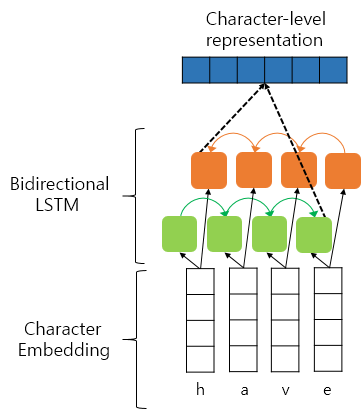

* 단어 'have'를 'h', 'a', 'v', 'e'와 같이 글자 단위로 분리
* 임베딩 층을 이용해 글자를 임베딩
* 정방향 LSTM은 단어 정방향으로 순차적으로 글자 임베딩 벡터를 읽고 역방향 LSTM은 단어의 역방향으로 순차적으로 글자 임베딩 벡터를 읽음
* 그리고 정방향 LSTM의 마지막 시점의 은닉 상태와 역방향 LSTM의 첫번째 시점의 은닉 상태를 연결(concatenate)함
* 최종적으로 이렇게 얻은 벡터를 단어 'have'의 벡터로 사용함

글자 임베딩을 워드 임베딩의 대체로서 쓸 수도 있겠지만, 이렇게 얻은 글자 임베딩을 워드 임베딩과 연결하여 신경망의 입력으로 사용하므로서 워드 임베딩과 함께 사용하기도 함